# Import Lib and settings

In [ ]:
import numpy as np
import trimesh
import pyrender
import matplotlib.pyplot as plt
import os

os.environ["PYOPENGL_PLATFORM"] = "egl"
os.environ["LIBGL_ALWAYS_SOFTWARE"] = "1"

#Config for debugging
SHOW_Y_AXIS = True
OURPUT_ROOT = '../resources/LOD_images'

# ICP Align

In [ ]:
def center_scene_origin_by_bbox(scene):
    # get min/max of x,y,z
    min_corner, max_corner = scene.bounds  # each is (3,)
    box_center = (min_corner + max_corner) * 0.5

    # translate so bounding‐box center → origin
    scene.apply_translation(-box_center)
    
    return scene

def center_scene_origin_by_centroid(scene):
    centroid = scene.centroid
    scene.apply_translation(-centroid)
    
    return scene

def get_register_matrix(mesh_to_move, other):
    """
    Register two meshes and display them in a scene.
    
    Parameters:
    mesh (trimesh.Trimesh): The first mesh to register.
    other (trimesh.Trimesh): The second mesh to register against the first.
    Returns:
    trimesh.Trimesh: The transformed mesh after registration.
    so we can transform the mesh to align with the other mesh. (the one that got transformed is the one that is passed as `mesh_to_move`)
    """
    matrix, cost = trimesh.registration.mesh_other(
        mesh_to_move,
        other,
        samples=3000, # number of points to sample for the fit
        scale=False,
        icp_first=1, # number of iterations for the first ICP step (1 means no first step)
        icp_final=30
    )
    
    return matrix, cost

def align_lods(lod_1_scene, lod_2_scene, lod_3_scene, verbose=True, center_before_align=True):
    if center_before_align:
        # Center the origin of each scene by its bounding box
        lod_1_scene = center_scene_origin_by_bbox(lod_1_scene)
        lod_2_scene = center_scene_origin_by_bbox(lod_2_scene)
        lod_3_scene = center_scene_origin_by_bbox(lod_3_scene)
    
    # extract lod_3_scene to mesh
    lod_3_mesh = trimesh.util.concatenate(list(lod_3_scene.geometry.values()))
    lod_2_mesh = trimesh.util.concatenate(list(lod_2_scene.geometry.values()))
    lod_1_mesh = trimesh.util.concatenate(list(lod_1_scene.geometry.values()))

    transform_matrix_2_to_1, cost_2_to_1 = get_register_matrix(lod_2_mesh, lod_1_mesh)
    transform_matrix_3_to_2 , cost_3_to_2 = get_register_matrix(lod_3_mesh, lod_2_mesh)
    #transform 3 to 1 by calculating the matrix from 3 to 2 and then from 2 to 1
    transform_matrix_3_to_1 = np.dot(transform_matrix_2_to_1, transform_matrix_3_to_2)
    
    if verbose:
        print(f"Transform matrix from LOD 2 to LOD 1:\n{transform_matrix_2_to_1}\n, Cost: {cost_2_to_1}")
        print(f"Transform matrix from LOD 3 to LOD 2:\n{transform_matrix_3_to_2}\n, Cost: {cost_3_to_2}")
        print(f"calculated matrix from LOD 3 to LOD 1:\n{transform_matrix_3_to_1}\n")
    
    return lod_1_scene, lod_2_scene, lod_3_scene

In [ ]:
lod_3_scene = trimesh.load("/home/jeans/win/aaaJAIST/resources/LOD_data_50/1/lod3.obj")
lod_2_scene = trimesh.load("/home/jeans/win/aaaJAIST/resources/LOD_data_50/1/lod2.obj")
lod_1_scene = trimesh.load("/home/jeans/win/aaaJAIST/resources/LOD_data_50/1/lod1.obj")

In [ ]:
lod_1_scene, lod_2_scene, lod_3_scene = align_lods(lod_1_scene, lod_2_scene, lod_3_scene, verbose=True)

# scene = trimesh.Scene()
# scene.add_geometry(lod_3_scene)
# scene.add_geometry(lod_2_scene)
# scene.add_geometry(lod_1_scene)
# scene.show()

# Orbit capture

In [ ]:
# --- Custom LookAt Matrix Function ---
def look_at_matrix(eye, target, up):
    """
    Create a camera pose matrix (camera-to-world) for PyRender
    """
    f = target - eye
    f = f / np.linalg.norm(f) # Forward vector (from eye to target)

    # If the forward vector is parallel to the up vector, adjust the up vector
    # to avoid numerical instability in the cross product.
    if np.isclose(np.linalg.norm(np.cross(f, up)), 0):
        # Pick a new 'up' vector that is not parallel to 'f'
        if np.isclose(np.abs(np.dot(f, np.array([0, 1, 0]))), 1):
            up = np.array([0, 0, 1]) # If f is vertical, use Z as up
        else:
            up = np.array([0, 1, 0]) # Otherwise, use Y as up

    s = np.cross(f, up)
    s = s / np.linalg.norm(s) # Right vector

    u = np.cross(s, f)
    u = u / np.linalg.norm(u) # Corrected Up vector

    # Construct the view matrix (world-to-camera)
    view_matrix = np.array([
        [s[0], s[1], s[2], -np.dot(s, eye)],
        [u[0], u[1], u[2], -np.dot(u, eye)],
        [-f[0], -f[1], -f[2], np.dot(f, eye)],  # Camera looks down -Z axis
        [0, 0, 0, 1]
    ])

    # PyRender expects a pose matrix (camera-to-world), so we invert the view matrix
    camera_pose = np.linalg.inv(view_matrix)
    
    return camera_pose


In [ ]:
bbox_center = (lod_3_scene.bounds[0] + lod_3_scene.bounds[1]) / 2

# Print for comparison
print(f"Original centroid: {lod_3_scene.centroid}")
print(f"Bounding box center: {bbox_center}")

# Translate mesh to center it at the bounding box center (not centroid)
lod_3_scene.apply_translation(-bbox_center)
lod_2_scene.apply_translation(-bbox_center)
lod_1_scene.apply_translation(-bbox_center)

# Verify the translation worked
print(f"New centroid after translation: {lod_3_scene.centroid}")
print(f"New bounding box center: {(lod_3_scene.bounds[0] + lod_3_scene.bounds[1]) / 2}")

# scene = pyrender.Scene.from_trimesh_scene(lod_3_scene)

Mesh bounds: [212.886     28.310478  93.954   ]
Mesh center: [-5.68434189e-14  8.88178420e-16 -2.84217094e-14]
Radius: 106.44300000000004


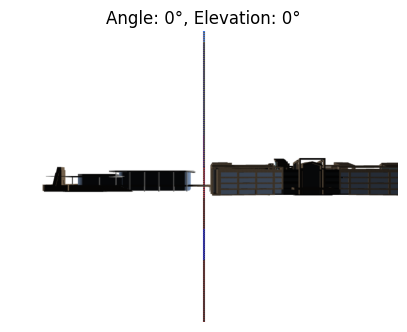

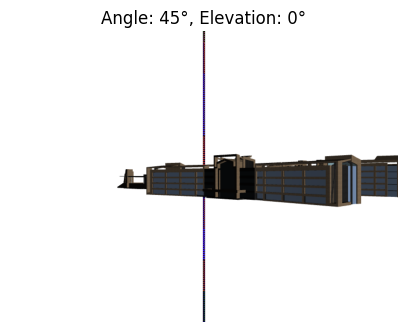

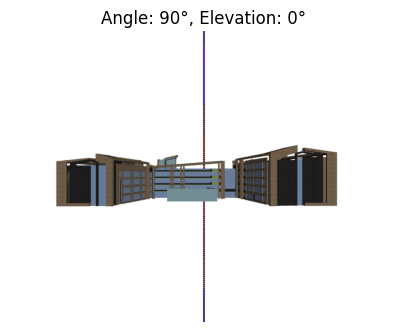

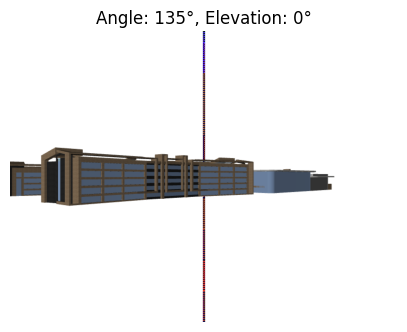

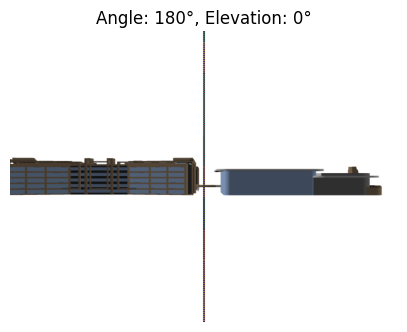

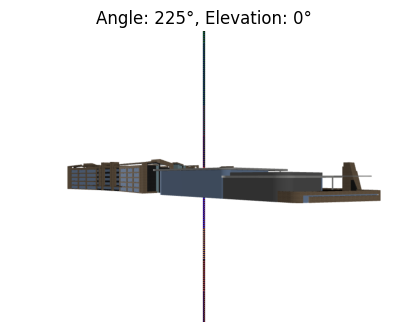

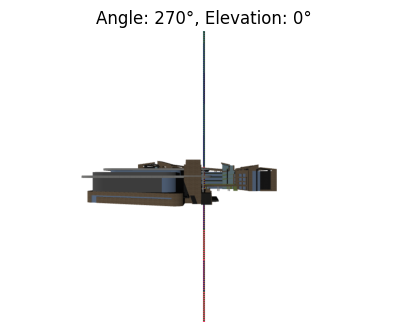

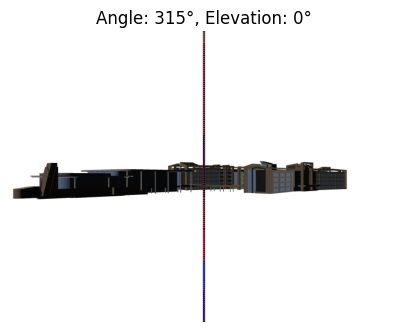

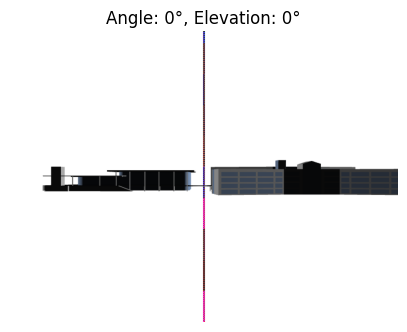

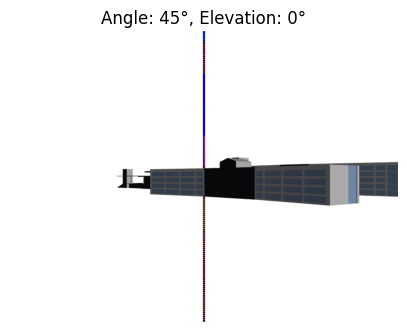

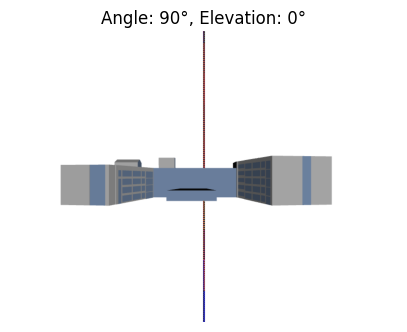

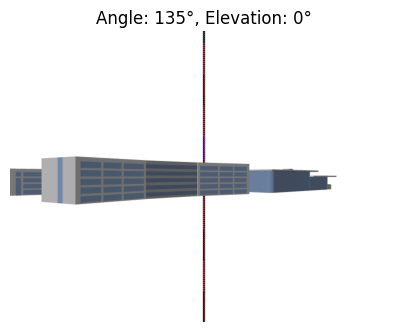

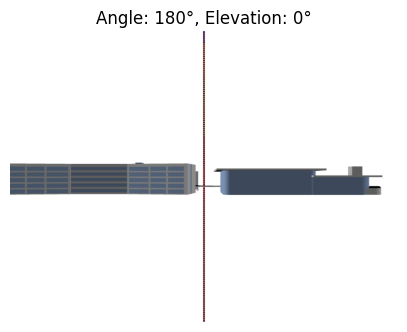

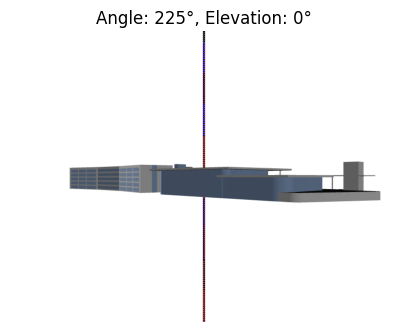

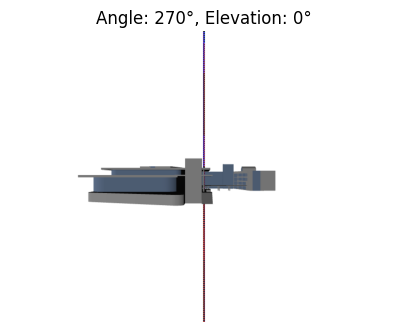

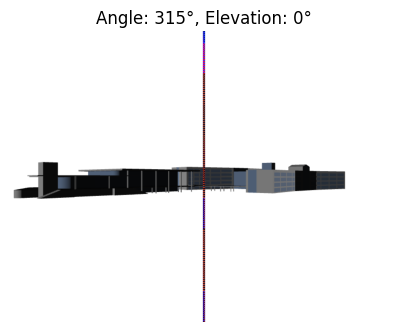

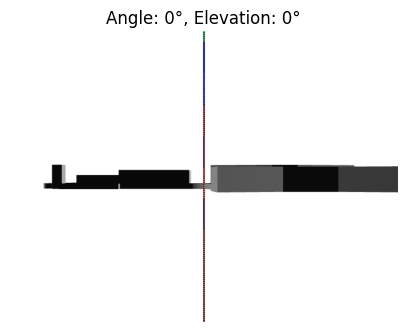

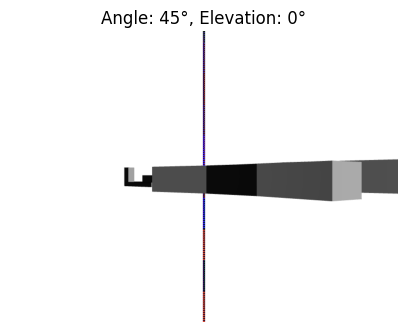

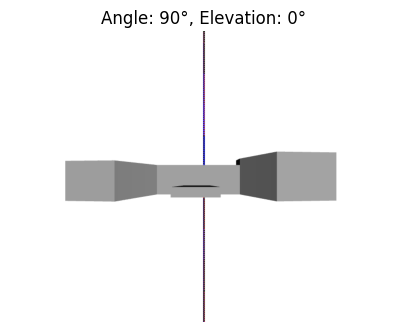

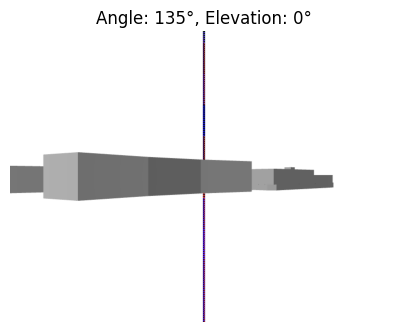

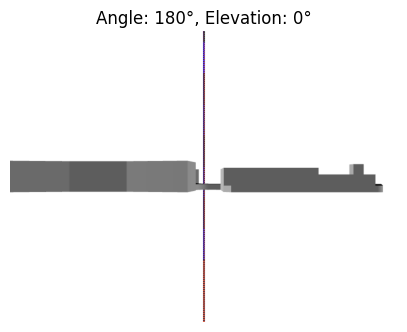

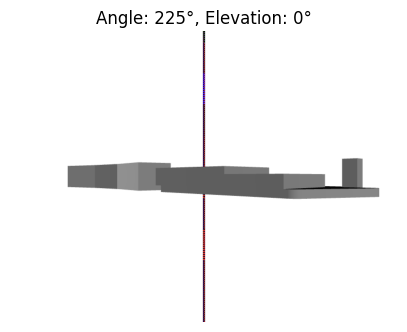

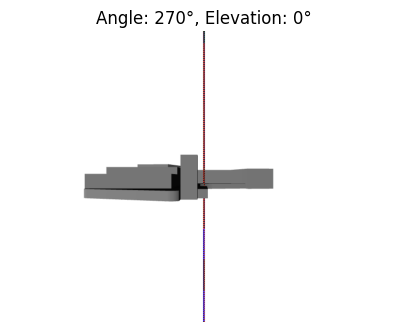

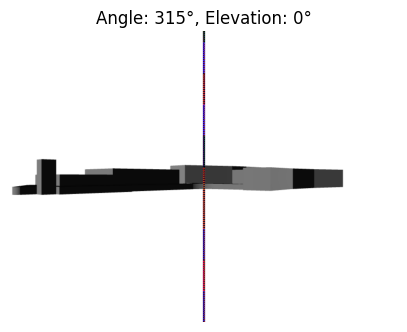

In [11]:
# Calculate bounding box for camera positioning
bounds = lod_3_scene.extents
center = lod_3_scene.centroid # This will now be [0,0,0] because we centered the mesh
radius = np.max(bounds) /2

print(f"Mesh bounds: {bounds}")
print(f"Mesh center: {center}")
print(f"Radius: {radius}")
    
    
for trimesh_scene in [lod_3_scene, lod_2_scene, lod_1_scene]:
    
    # Setup Pyrender scene and renderer
    scene = pyrender.Scene.from_trimesh_scene(trimesh_scene) # Add the main mesh
    r = pyrender.OffscreenRenderer(800, 600)

    if SHOW_Y_AXIS:
        bbox_mesh = trimesh.primitives.Box(extents=[1,100000,1])
        bbox_material = pyrender.Material(wireframe=True)
        bbox_pyrender_mesh = pyrender.Mesh.from_trimesh(bbox_mesh, material=bbox_material)
        scene.add(bbox_pyrender_mesh)
        
        
    # Raymond lighting (as in your original code)
    intensity = 3.0

    key = pyrender.DirectionalLight(color=np.ones(3), intensity=intensity)
    key_pose = np.array([
        [ 0,  0,  1,  2],
        [ 0,  1,  0,  2],
        [ 1,  0,  0,  2],
        [ 0,  0,  0,  1],
    ])
    scene.add(key, pose=key_pose)

    fill = pyrender.DirectionalLight(color=np.ones(3), intensity=intensity * 0.5)
    fill_pose = np.array([
        [ 0,  0, -1, -2],
        [ 0,  1,  0,  1],
        [-1,  0,  0, -2],
        [ 0,  0,  0,  1],
    ])
    scene.add(fill, pose=fill_pose)

    back = pyrender.DirectionalLight(color=np.ones(3), intensity=intensity * 0.3)
    back_pose = np.array([
        [ 1,  0,  0, -2],
        [ 0,  0,  1, -2],
        [ 0,  1,  0,  2],
        [ 0,  0,  0,  1],
    ])
    scene.add(back, pose=back_pose)
    # --- Camera Setup and Rendering Loop ---
    camera_distance_factor = 2.0
    camera_node = None

    # Test with just a few angles first to debug
    for camera_angle_deg in range(0, 360, 45):  # Changed to 45 degree steps for testing
        for camera_elevation_deg in range(0, 15, 15): # This loop will only run for elevation=0
            camera_angle_rad = np.deg2rad(camera_angle_deg)
            camera_elevation_rad = np.deg2rad(camera_elevation_deg)

            # Calculate camera position in spherical coordinates
            x = radius * camera_distance_factor * np.cos(camera_elevation_rad) * np.sin(camera_angle_rad)
            y = radius * camera_distance_factor * np.sin(camera_elevation_rad)
            z = radius * camera_distance_factor * np.cos(camera_elevation_rad) * np.cos(camera_angle_rad)

            eye = np.array([x, y, z])  # Camera position
            target = np.array([0.0, 0.0, 0.0])  # Look at origin (where we centered the mesh)
            up = np.array([0.0, 1.0, 0.0])  # World up vector

            # print(f"Camera angle: {camera_angle_deg}°, elevation: {camera_elevation_deg}°")
            # print(f"Eye position: {eye}")
            # print(f"Target position: {target}")
            # print(f"Distance from eye to target: {np.linalg.norm(eye - target)}")

            camera_pose = look_at_matrix(eye, target, up)
            # print(f"Camera pose matrix:\n{camera_pose}")

            camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)
            
            if camera_node is not None:
                scene.remove_node(camera_node)
            
            camera_node = scene.add(camera, pose=camera_pose)

            color, _ = r.render(scene)

            # save the image to corresponing folders
            color = color[:, :, :3] # Remove alpha channel if present
            # os.makedirs(f'OURPUT_ROOT/{scene_number}/{lod_number}/{angle}/{elevation}/{image name : use "scenenumber_lodnumber_angle_elevation.png"}', exist_ok=True)
            
            plt.figure(figsize=(5, 5))
            plt.axis('off')
            plt.imshow(color)
            plt.title(f'Angle: {camera_angle_deg}°, Elevation: {camera_elevation_deg}°')
            plt.show()

    r.delete()